In [ ]:
import pandas as pd
import numpy as np
from itertools import combinations
import math

# Reading the data sets. First one has count of number of followers each user has and second has a few edges. We use both to do link/edge prediction.
followers_count_dataSet = pd.read_csv('D:/2-1/SMA/Project/FinalSubmission/instagram_70k.csv', usecols=[0, 2, 3])
dataset_with_few_edges = pd.read_csv('D:/2-1/SMA/Project/FinalSubmission/NetworkforIC.csv', usecols=[0, 1])

# Adding names for easy identification
followers_count_dataSet.columns = ['node_id', 'followers_count', 'following_count']
dataset_with_few_edges.columns = ['source_node', 'follower_node']

# Creating maps for maps: followers. This gives time complexity O(1)
followers_map = dataset_with_few_edges.groupby('source_node')['follower_node'].apply(set).to_dict()

# Degree is followers a user has.
degree_map = followers_count_dataSet.set_index('node_id')['followers_count'].to_dict()

'''
Finding missed links using link prediction methods:
	local heuristics:
		common neighbors
		adamic adar
		preferential attachment
		jaccard coefficient
'''
def calculate_scores(node_1, node_2):
    followers_node1 = followers_map.get(node_1, set())
    followers_node2 = followers_map.get(node_2, set())
    common_followers = followers_node1.intersection(followers_node2)
    

    
    # Jaccard's Coefficient
    jc = len(followers_node1.intersection(followers_node2)) / len(followers_node1.union(followers_node2)) if followers_node1.union(followers_node2) else 0
    
    # Adamic Adar 
    aa = sum(1 / math.log(degree_map.get(z, 1.0)) for z in common_followers if degree_map.get(z, 1.0) > 1)
    
    # Preferential Attachment
    pa = degree_map.get(node_1, 0) * degree_map.get(node_2, 0)

    # Common Neighbors
    cn = len(common_followers)
    
    return cn, jc, aa, pa

# Process chunk within given range.
def process_node_chunks(nodePairs, current_chunk_id, existing_followers):
    predicted_links = []
    for node_1, node_2 in nodePairs:
        if node_1 in existing_followers and node_2 in existing_followers[node_1]:
            # if current one is a follower, skip
            continue
        cn, jc, aa, pa = calculate_scores(node_1, node_2)
        
        # Using lesser thresholds as we have very few connections given in second data second. Mostly less than 10%
        cn_threshold = 1
        jc_threshold = 0.01
        aa_threshold = 0.6
        pa_threshold = 1000
        
        if cn > cn_threshold and jc > jc_threshold and aa > aa_threshold and pa > pa_threshold:
            predicted_links.append((node_1, node_2))
    
    # Saving the predicted links to a new dataframe
    new_predicted_links = pd.DataFrame(predicted_links, columns=['source_node', 'destination_node'])
    
    # Concatenating with existing followers
    existing_df_chunk = pd.DataFrame([(node, follower) for node, followers in existing_followers.items() for follower in followers], columns=['source_node', 'destination_node'])
    combined_df_chunk = pd.concat([existing_df_chunk, new_predicted_links]).drop_duplicates().reset_index(drop=True)
    
    # Saving the predictions to a new CSV file. We are using this in second program as input.
    output_path = f'D:/2-1/SMA/Project/FinalSubmission/predictedlinks_{current_chunk_id}.csv'
    combined_df_chunk.to_csv(output_path, index=False)
    
    print(f"Predicted-new links CSV file is saved to {output_path}")

# No. of nodes being processed in each chunk.
chunk_size = 2000

# Iterator for all nodes from first data set. Though its unique, using unique function for safety.
unique_nodes = followers_count_dataSet['node_id'].unique()
all_node_pairs = combinations(unique_nodes, 2)

current_chunk_id = 1

# Iterate over node pairs in chunks eg:1 to 5k, 5k to 10k etc
for i in range(0, len(unique_nodes), chunk_size):
    # Selecting a subset of nodes
    node_subset = unique_nodes[i:i+chunk_size]
    
    # Creating all pairs for the current subset
    nodePairs = combinations(node_subset, 2)
    
    # Processing the pairs to see a possibility of connection.
    process_node_chunks(nodePairs, current_chunk_id, followers_map)
    
    current_chunk_id += 1   #Looping all pairs till end.


Predicted-new links CSV file is saved to D:/2-1/SMA/Project/FinalSubmission/predictedlinks_1.csv
Predicted-new links CSV file is saved to D:/2-1/SMA/Project/FinalSubmission/predictedlinks_2.csv
Predicted-new links CSV file is saved to D:/2-1/SMA/Project/FinalSubmission/predictedlinks_3.csv
Predicted-new links CSV file is saved to D:/2-1/SMA/Project/FinalSubmission/predictedlinks_4.csv
Predicted-new links CSV file is saved to D:/2-1/SMA/Project/FinalSubmission/predictedlinks_5.csv
Predicted-new links CSV file is saved to D:/2-1/SMA/Project/FinalSubmission/predictedlinks_6.csv
Predicted-new links CSV file is saved to D:/2-1/SMA/Project/FinalSubmission/predictedlinks_7.csv
Predicted-new links CSV file is saved to D:/2-1/SMA/Project/FinalSubmission/predictedlinks_8.csv
Predicted-new links CSV file is saved to D:/2-1/SMA/Project/FinalSubmission/predictedlinks_9.csv
Predicted-new links CSV file is saved to D:/2-1/SMA/Project/FinalSubmission/predictedlinks_10.csv
Predicted-new links CSV file 

In [ ]:
import pandas as pd
import numpy as np
import math
from itertools import combinations
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import eigsh


# Reading the data sets. First one has count of number of followers each user has and second has a few edges. We use both to do link/edge prediction.
followers_count_dataSet = pd.read_csv('D:/2-1/SMA/Project/FinalSubmission/instagram_subdata.csv', usecols=[0, 2, 3])
dataset_with_few_edges = pd.read_csv('D:/2-1/SMA/Project/FinalSubmission/NetworkforIC.csv', usecols=[0, 1])

# Adding names for easy identification
followers_count_dataSet.columns = ['node_id', 'followers_count', 'following_count']
dataset_with_few_edges.columns = ['source_node', 'follower_node']

# Creating maps for maps: followers. This gives time complexity O(1)
followers_map = dataset_with_few_edges.groupby('source_node')['follower_node'].apply(set).to_dict()

# Degree is followers a user has.
degree_map = followers_count_dataSet.set_index('node_id')['followers_count'].to_dict()

'''
Finding missed links using link prediction methods:
	local heuristics:
		common neighbors
		adamic adar
		preferential attachment
		jaccard coefficient
'''
def calculate_scores(node_1, node_2):
    followers_node1 = followers_map.get(node_1, set())
    followers_node2 = followers_map.get(node_2, set())
    common_followers = followers_node1.intersection(followers_node2)
    

    
    # Jaccard's Coefficient
    jc = len(followers_node1.intersection(followers_node2)) / len(followers_node1.union(followers_node2)) if followers_node1.union(followers_node2) else 0
    
    # Adamic Adar 
    aa = sum(1 / math.log(degree_map.get(z, 1.0)) for z in common_followers if degree_map.get(z, 1.0) > 1)
    
    # Preferential Attachment
    pa = degree_map.get(node_1, 0) * degree_map.get(node_2, 0)

    # Common Neighbors
    cn = len(common_followers)
    
    return cn, jc, aa, pa

# Finding Katz Centrality using the power method
def find_katz_centrality(adj_matrix_subset, alpha=0.005, max_iter=1200, tolerance=1e-5):
    n = adj_matrix_subset.shape[0]
    # Initializing with degree vector
    ret_Katz_centrality = np.ones((n, 1))
    # Using the power method in Katz ret_Katz_centrality
    for _ in range(max_iter):
        prev_centrality = ret_Katz_centrality
        ret_Katz_centrality = alpha * adj_matrix_subset.dot(ret_Katz_centrality) + np.ones((n, 1))
        if np.linalg.norm(ret_Katz_centrality - prev_centrality, ord=1) < tolerance:             # Checking for convergence
            break
    return ret_Katz_centrality

# Function we use to generate the adjacency matrix for a subset of nodes
def generate_adjacency_matrix(nodes_subset, followers_map):
    size = len(nodes_subset)
    matrix = np.zeros((size, size))
    node_to_index = {node: index for index, node in enumerate(nodes_subset)}
    
    for node in nodes_subset:
        followers = followers_map.get(node, set())
        for follower in followers:
            if follower in node_to_index:  # We are considering followers data only within the subset
                matrix[node_to_index[node]][node_to_index[follower]] = 1
    return csr_matrix(matrix)

# Process chunk within given range.
def process_node_chunks(nodes_subset, chunk_index):
    # Generating adjacency matrix for the current subset as given in the index range based on chunk size
    adj_matrix_subset = generate_adjacency_matrix(nodes_subset, followers_map)
    
    katz_centrality = find_katz_centrality(adj_matrix_subset)
    
    # Here we store the predicted data links
    predicted_links_df = pd.DataFrame(columns=['source_node', 'destination_node'])
    
    # Iterate over all pairs and compute heuristic scores
    for i, node_1 in enumerate(nodes_subset):
        for j, node_2 in enumerate(nodes_subset):
            if i != j:
                # Calculate heuristic scores
                cn, jc, aa, pa = calculate_scores(node_1, node_2)
                
                # Thresholds for deciding whether to connect nodes
                cn_threshold = 1
                jc_threshold = 0.01
                aa_threshold = 0.5
                pa_threshold = 1000
                katz_threshold = 0.1  # Katz score threshold
                
                # Check if pair exceeds all thresholds
                if ((cn > cn_threshold and jc > jc_threshold and aa > aa_threshold and pa > pa_threshold) or  
                    (katz_centrality[i] > katz_threshold and katz_centrality[j] > katz_threshold)):
                    new_row = pd.DataFrame({
                        'source_node': [node_1], 
                        'destination_node': [node_2]
                    })
                    predicted_links_df = pd.concat([predicted_links_df, new_row], ignore_index=True)

    # Concatenating with existing followers
    existing_df_chunk = pd.DataFrame([(node, follower) for node, followers in followers_map.items() 
                                    for follower in followers if node in nodes_subset], 
                                    columns=['source_node', 'destination_node'])
    combined_df_chunk = pd.concat([existing_df_chunk, predicted_links_df]).drop_duplicates().reset_index(drop=True)     #Also eliminating duplicates
    
    # Saving the predictions to a new CSV file. We are using this in second program as input.
    output_path = f'D:/2-1/SMA/Project/FinalSubmission/predictedlinksUpdated_{chunk_index}.csv'
    combined_df_chunk.to_csv(output_path, index=False)
    
    print(f"Predicted links CSV file saved to {output_path}")

# Max nodes we process in each chunk
max_chunk_size = 300

# Iterator for all nodes from first data set. Though its unique, using unique function for safety.
unique_nodes = followers_count_dataSet['node_id'].unique()
all_node_pairs = combinations(unique_nodes, 2)

# Processing each subset of nodes
for chunk_index, i in enumerate(range(0, len(unique_nodes), max_chunk_size), start=1):
    nodes_subset = unique_nodes[i:i + max_chunk_size]
    process_node_chunks(nodes_subset, chunk_index)



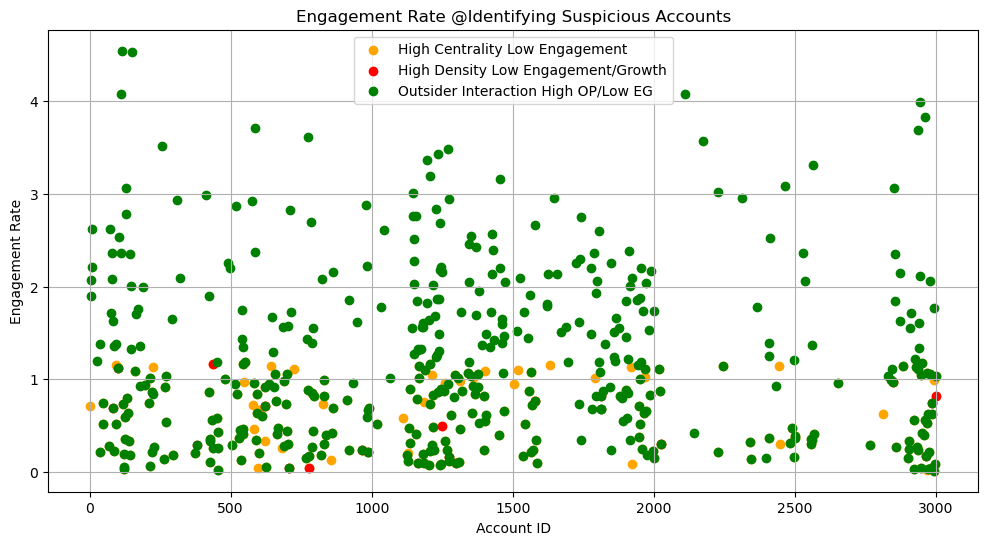

In [3]:
import numpy as np
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import minmax_scale

# Load the datasets
insta_data = pd.read_csv('D:/2-1/SMA/Project/FinalSubmission/instagram_subdata.csv')
predicted_links = pd.read_csv('D:/2-1/SMA/Project/FinalSubmission/predictedlinks_1.csv')

# Finding the  eigenvector centrality
new_graph = nx.from_pandas_edgelist(predicted_links, 'source_node', 'destination_node')
ev_centrality = nx.eigenvector_centrality_numpy(new_graph)

# Normalizing the centrality scores
normalized_centrality = minmax_scale(list(ev_centrality.values()))

# Calculating the network density. An account with high density and low engagement rate and low growth rate and low outsider reach is also suspicious
density = nx.density(new_graph)

# Ensuring we match the correct accounts
insta_data['eigenvector_centrality'] = insta_data['id'].map(ev_centrality)

# Identifying suspicious accounts: An account with high eigenvector centrality but low engagement rates could be suspicious.
low_engagement_threshold = insta_data['er'].quantile(0.1)
low_growth_threshold = insta_data['fg'].quantile(0.1)

ret_suspicious_wrt_centrality = insta_data[
    (insta_data['eigenvector_centrality'] > insta_data['eigenvector_centrality'].median()) & 
    (insta_data['er'] < low_engagement_threshold)
]

# Suspicious pattern 2: an account with high density and low engagement rate and low growth rate and low outsider reach is also suspicious
suspicious_accounts_high_density = insta_data[
    (insta_data['er'] < low_engagement_threshold) & 
    (insta_data['fg'] < low_growth_threshold) & 
    (insta_data['op'] < insta_data['op'].median())
]

# Outsider Interaction Analysis:- We will examine the ratio of outsider interactions (op) to the engagement grade (eg) to identify anomalies.
insta_data['op_to_eg_ratio'] = insta_data['op'] / insta_data['eg']

# Normalize the op_to_eg_ratio
insta_data['op_to_eg_ratio_norm'] = minmax_scale(insta_data['op_to_eg_ratio'])

# Identifying accounts with abnormal outsider interaction ratios
abnormal_outsider_interaction_threshold = insta_data['op_to_eg_ratio_norm'].quantile(0.85)
suspicious_accounts_outsider_interaction = insta_data[
    insta_data['op_to_eg_ratio_norm'] > abnormal_outsider_interaction_threshold
]

# Plotting the graph to find outliers
plt.figure(figsize=(12, 6))
#plt.plot(insta_data['id'], insta_data['er'], label='Engagement Rate')
plt.scatter(ret_suspicious_wrt_centrality['id'],
            ret_suspicious_wrt_centrality['er'],
            color='orange', label='High Centrality Low Engagement')
plt.scatter(suspicious_accounts_high_density['id'],
            suspicious_accounts_high_density['er'],
            color='red', label='High Density Low Engagement/Growth')

plt.scatter(suspicious_accounts_outsider_interaction['id'],
            suspicious_accounts_outsider_interaction['er'],
            color='green', label='Outsider Interaction High OP/Low EG')
plt.xlabel('Account ID')
plt.ylabel('Engagement Rate')
plt.title('Engagement Rate @Identifying Suspicious Accounts')
plt.legend()
plt.grid(True)
plt.show()


#Please note the points of intersections shows high probability of anamolies i.e fake accounts.